In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [2]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# DATA IS UNBALANCED

In [3]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
Normal = data[data.Class == 0]
Fraud = data[data.Class == 1]

# Under Sampling

In [5]:
Normal = Normal.sample(n = Fraud.shape[0])
Normal.shape ,  Fraud.shape

((492, 31), (492, 31))

In [6]:
new_data = pd.concat([Normal,Fraud] , axis = 0)
new_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
218775,141454.0,1.820435,-0.676183,-0.436427,0.072280,-0.548585,0.093738,-0.616183,0.079451,1.056892,...,0.284753,0.898057,0.086707,0.842891,-0.172196,0.057708,0.001671,-0.029569,79.95,0
242546,151539.0,2.056321,-1.829648,-0.732793,-1.353940,-1.765126,-0.863630,-1.139042,-0.204751,-0.924425,...,-0.086128,-0.013440,0.159245,-0.059305,-0.344454,-0.184234,-0.000413,-0.026384,132.00,0
686,518.0,-0.743471,0.943604,1.486464,-0.179575,-0.190966,-0.295559,0.352438,0.354958,-0.110108,...,-0.195239,-0.553503,0.055946,0.134419,-0.356895,0.083846,0.372062,0.162031,4.45,0
161119,113897.0,-1.324505,-0.839761,0.514422,-0.783013,2.287447,-1.629546,0.004678,0.065247,-0.299259,...,-0.030201,-0.564631,0.240656,-0.425941,-0.566437,0.022976,0.037823,0.192397,0.89,0
243902,152120.0,2.112514,0.669729,-2.814950,0.474951,1.289255,-0.927122,0.404925,-0.352857,0.318982,...,0.059662,0.413336,-0.122381,-0.142590,0.427755,-0.095410,0.023992,0.010520,1.00,0


In [7]:
X = new_data.drop('Class',axis = 1)
Y = new_data['Class']

In [8]:
scaler =  StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X_train , X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 101)

In [10]:
input_shape = (X_train.shape[1],1)
input_shape

(30, 1)

In [11]:
inputs = tf.keras.layers.Input(input_shape)
l1 = tf.keras.layers.LSTM(64, activation = 'tanh')(inputs)
l1 = tf.keras.layers.Dropout(0.20)(l1)
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid')(l1)
model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=20,verbose=1),
            tf.keras.callbacks.ModelCheckpoint('Fraud_Detection_Model.h5',verbose=1,save_best_only=True)]


results = model.fit(X_train.reshape(X_train.shape[0],X_train.shape[1],1),Y_train,validation_split = 0.20,epochs=100, callbacks = callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.7472
Epoch 1: val_loss improved from inf to 0.46719, saving model t

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/20 [===========================>..] - ETA: 0s - loss: 0.4040 - accuracy: 0.8158
Epoch 2: val_loss improved from 0.46719 to 0.42100, saving model to Fraud_Detection_Model.h5
20/20 [==============================] - 0s 20ms/step - loss: 0.4042 - accuracy: 0.8172 - val_loss: 0.4210 - val_accuracy: 0.8101
Epoch 3/100
17/20 [========================>.....] - ETA: 0s - loss: 0.3698 - accuracy: 0.8346
Epoch 3: val_loss improved from 0.42100 to 0.41180, saving model to Fraud_Detection_Model.h5
20/20 [==============================] - 0s 21ms/step - loss: 0.3756 - accuracy: 0.8347 - val_loss: 0.4118 - val_accuracy: 0.8101
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3697 - accuracy: 0.8339
Epoch 4: val_loss improved from 0.41180 to 0.40582, saving model to Fraud_Detection_Model.h5
20/20 [==============================] - 0s 22ms/step - loss: 0.3714 - accuracy: 0.8331 - val_loss: 0.4058 - val_accuracy: 0.8354
Epoch 5/100
19/20 [===========================>..] - ETA: 

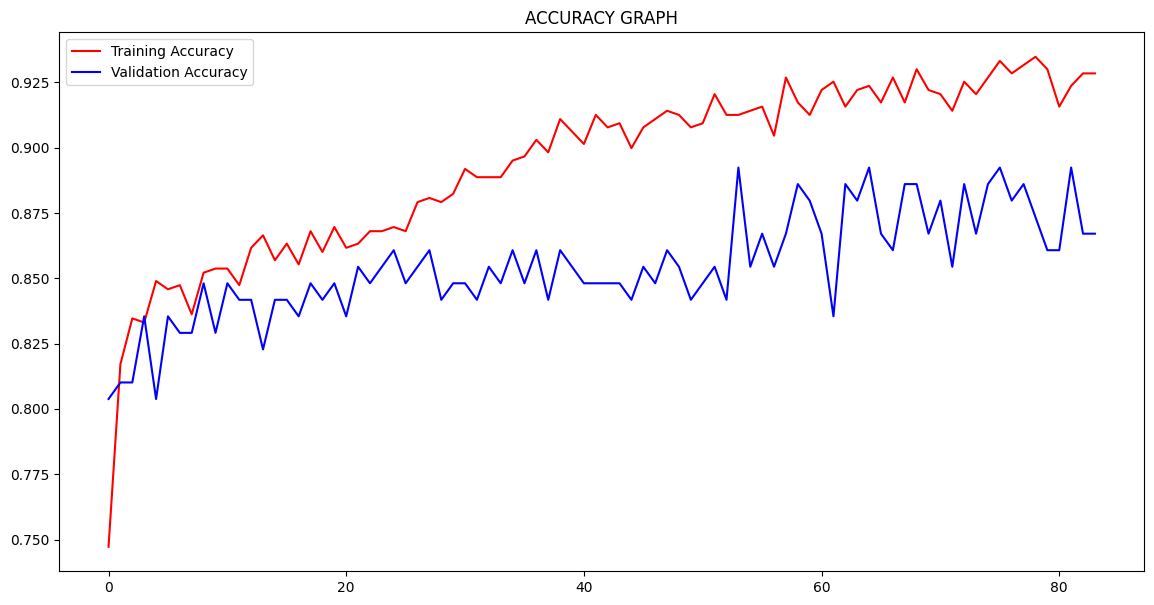

In [12]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title("ACCURACY GRAPH")
plt.show()

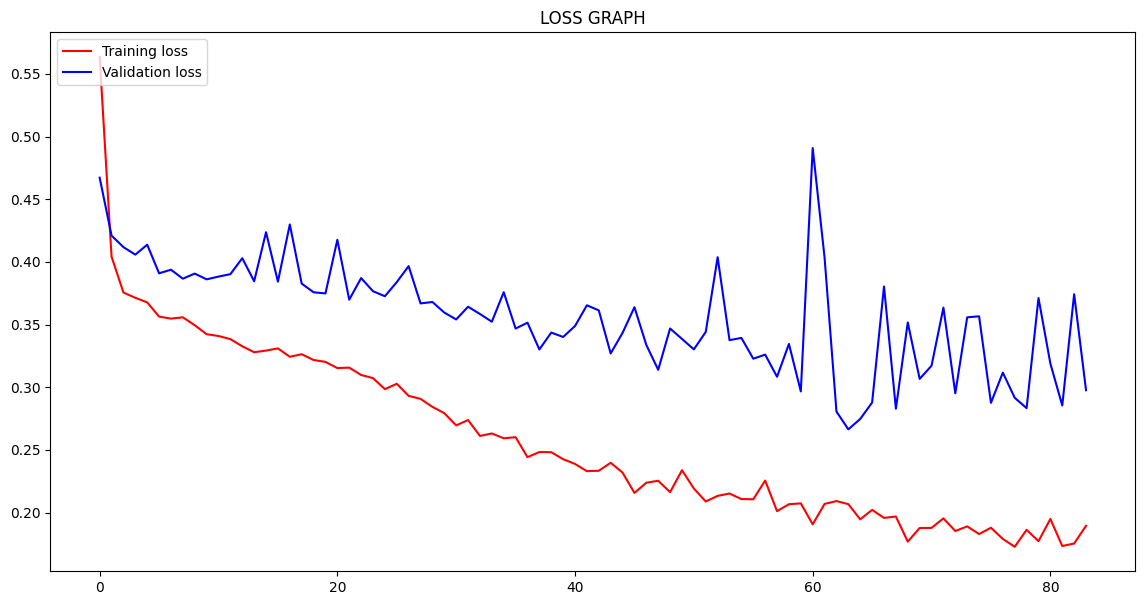

In [13]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.title("LOSS GRAPH")
plt.show()

In [14]:
model.evaluate(X_test.reshape(X_test.shape[0],X_test.shape[1],1),Y_test,verbose = 1)

7/7 [==============================] - 0s 5ms/step - loss: 0.2284 - accuracy: 0.9188


[0.22838914394378662, 0.9187816977500916]

In [15]:
y_pred = model.predict(X_test.reshape(X_test.shape[0],X_test.shape[1],1)) 
y_pred = (y_pred > 0.5).astype(int)
print("Confusion Matrix:")
con_list = confusion_matrix(Y_test,y_pred)
print("\t\tPositive\t Negative\n")
print("Positive\t",con_list[0][0],"(TP)","\t",con_list[0][1],"(FP)\n")
print("Negative\t",con_list[1][0],"(FN)","\t",con_list[1][1],"(TN)\n\n")
print(classification_report(Y_test,y_pred))


7/7 [==============================] - 1s 7ms/step
Confusion Matrix:
		Positive	 Negative

Positive	 98 (TP) 	 3 (FP)

Negative	 13 (FN) 	 83 (TN)


              precision    recall  f1-score   support

           0       0.88      0.97      0.92       101
           1       0.97      0.86      0.91        96

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197

